En este tema vamos a aprender a emplear una **CNN preentrenada** con un gran conjunto de datos para la resolución de un problema de clasificación diferente al problema para el que fue entranada dicha CNN.

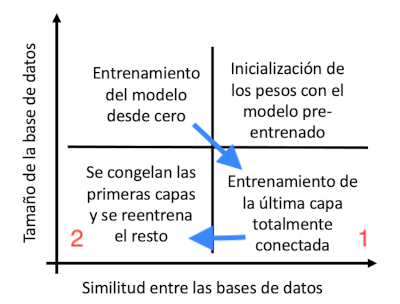

En esta tema vamos a ver como implementar dos tipos diferentes de transferencia de conocimiento para la resolución del problema de clasificación de imágenes de perros y gatos.

1. **Extracción de características**: se congelan todas las capas encargardas de la extracción de características y únicamente se entrena una última capa de clasificación. 

2. **Ajuste fino**: se descongelan las capas convolucionales encargadas de la extracción de características y se entrena toda la CNN durante unas pocas épocas para adaptar las características al nuevo problema.

# Carga de las imágenes

Vamos a aprender otra forma de cargar los datos y emplearlos para el entrenamiento de nuestros modelos. Descargaremos las imágenes de una API, en este caso la de Google, almacenaremos los datos en nuestro sistema de archivos y, a continuación, emplearemos el método image_dataset_from_directory para cargarlos.

In [177]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout

import os

import numpy as np

import matplotlib.pyplot as plt

In [178]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

In [179]:
# Vemos el directorio en el que se ha almacenado el zip descargado
print(path_to_zip)

/root/.keras/datasets/cats_and_dogs.zip


In [180]:
# Vemos que contiene la carpeta descargada
print(os.listdir(os.path.dirname(path_to_zip)))

['cats_and_dogs_filtered', 'cats_and_dogs.zip']


In [181]:
# Creamos el enlace al directorio donde se encuentran las imágenes y vemos qué contiene
path_images = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(os.listdir(path_images))

['validation', 'vectorize.py', 'train']


In [182]:
# Creamos enlaces a los directorios con las imágenes de entrenamiento y validación
path_train = os.path.join(path_images, 'train')
path_validation = os.path.join(path_images, 'validation')

In [183]:
# Vemos cómo están organizados los directorios
print(os.listdir(path_validation))

['dogs', 'cats']


Vamos a emplear el método [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) de tensorflow para crear los datasets de entrenamiento y validación. En este método las etiquetas son inferidas, es decir, genera lotes de imágenes de los subdirectorios dentro de la carpeta, asignándoles etiquetas diferentes (cats -> 0, dogs -> 1). Si no se especifica de otra forma, la asignación de etiquetas se realiza en orden alfabético. 

Este método permite leer imágenes de manera dinámica del sistema de archivos sin tener que cargarlas todas en la memoria RAM del ordenador. Esto permite trabajar con conjuntos de imágenes más grandes y/o cuando no dispongamos de máquinas con RAM elevada.

Es compatible con archivos en formato JPEG, PNG, BMP y GIF.

In [184]:
# Vamos a emplear el método image_dataset_from_directory de tensorflow para crear los datasets

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(path_train,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_and_test_dataset = image_dataset_from_directory(path_validation,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [185]:
# No es un Pandas Dataframe
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [186]:
train_dataset.class_names

['cats', 'dogs']

En los logs podemos ver lo que se ha encontrada en cada llamada a image_dataset_from_directory. En el caso del dataset de entrenamiento se han encontrado 2000 archivos pertenecientes a 2 clases diferentes y en el caso del dataset de validación se han encontrado 1000 archivos de dos clases diferentes. 

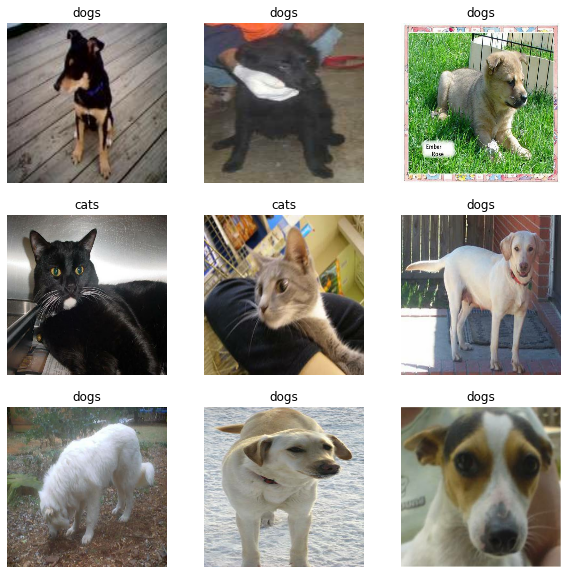

In [187]:
# Visualizamos imágenes y etiqueta correspondiente del conjunto de entrenamiento

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [188]:
# Guardamos parte del conjunto de datos de validación para el test externo

val_batches = tf.data.experimental.cardinality(validation_and_test_dataset) # Devuleve el nº de batches: 32. Por casualidad coincide con el tamaño de batch
# tf.data.experimental.cardinality(train_dataset)
print('Número de lotes de validación: ', val_batches.numpy())
test_dataset = validation_and_test_dataset.take(val_batches // 5)
validation_dataset = validation_and_test_dataset.skip(val_batches // 5)

Número de lotes de validación:  32


In [189]:
print('Número de lotes de validiación: ', tf.data.experimental.cardinality(validation_dataset).numpy())
print('Número de lotes de test: ', tf.data.experimental.cardinality(test_dataset).numpy())

Número de lotes de validiación:  26
Número de lotes de test:  6


El siguiente bloque de código se añade por defecto cuando queramos leer imágenes del sistema de archivos de manera dinámica para evitar que la E/S se bloquee. Permite mejorar el rendimiento en la carga de datos.

In [190]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# CNN desde cero

Vamos a implementar un CNN y entrenarla desde cero para tomarla como base para la comparativa con la transferencia de conocimiento.

Por lo tanto, en primer lugar vamos a preparar los datos. 
Las imágenes se encuentran en un rango entre [0, 255] por lo que tenemos que convertirlas a un rango entre [0, 1]. Esta vez, en lugar de preprocesar las imágenes previamente, vamos a crear una capa de reescalado que incluiremos en nuestra arquitectura. 

In [191]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255., offset= 0)

Vamos a emplear la misma arquitectura que la última que diseñamos en la sesión anterior. Pero a la que le incluiremos la capa de reescalado y la vamos a implementar haciendo uso del método Model en lugar de Sequential. Vamos a emplear un número de épocas de 10 para evitar largos tiempos de cálculo.

In [192]:
def create_cnn():

    input = Input(shape=(160, 160, 3))
    # Capa de reescalado
    x = rescale(input)
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Clasificación binaria
    output = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input], outputs=[output])
  
    return model

model_base = create_cnn()
model_base.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 160, 160, 128)     3584      
                                                                 
 batch_normalization_24 (Bat  (None, 160, 160, 128)    512       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 160, 160, 128)     147584    
                                                                 
 batch_normalization_25 (Bat  (None, 160, 160, 128)    512       
 chNormalization)                                          

In [193]:
# Ejecutar con GPU (10 minutos con GPU en Colab)

model_base.compile(optimizer = 'adam', 
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

history_base = model_base.fit(train_dataset,
                              epochs = 10,
                              validation_data = validation_dataset,
                              verbose = 1)

Epoch 1/10
63/63 [==============================] - 65s 1s/step - loss: 24.9568 - accuracy: 0.5365 - val_loss: 1033.0942 - val_accuracy: 0.5186
Epoch 2/10
63/63 [==============================] - 63s 1s/step - loss: 0.7531 - accuracy: 0.5425 - val_loss: 279.3166 - val_accuracy: 0.5111
Epoch 3/10
63/63 [==============================] - 63s 1s/step - loss: 0.6865 - accuracy: 0.5555 - val_loss: 126.3742 - val_accuracy: 0.5161
Epoch 4/10
63/63 [==============================] - 64s 1s/step - loss: 0.6763 - accuracy: 0.5690 - val_loss: 6.5605 - val_accuracy: 0.5248
Epoch 5/10
63/63 [==============================] - 64s 1s/step - loss: 0.6498 - accuracy: 0.5495 - val_loss: 3.7290 - val_accuracy: 0.5037
Epoch 6/10
63/63 [==============================] - 64s 1s/step - loss: 0.6475 - accuracy: 0.5955 - val_loss: 7.7372 - val_accuracy: 0.5050
Epoch 7/10
63/63 [==============================] - 64s 1s/step - loss: 0.6503 - accuracy: 0.6015 - val_loss: 1.2927 - val_accuracy: 0.5037
Epoch 8/10
6

In [194]:
#@title save_model() function
# Save the model

import pandas as pd
def save_model(model, filename):

  modelName = os.path.basename(filename)
  if modelName.endswith('.zip'):
      modelName = modelName[:-4]
  else:
    if modelName.endswith('.h5'):
      modelName = modelName[:-3]

  model.save(modelName)
  model.save(filename+'.h5')
  print('filename:', filename)
  print('modelName:', modelName)
  !zip -r {filename}.zip {modelName}
  history_df = pd.DataFrame(model.history.history)
  history_df.to_csv(filename+'.history.csv')


In [195]:
#@title load_model() function
# Cargar el modelo

import pandas as pd
def load_model(filename):

    modelName = os.path.basename(filename)
    if modelName.endswith('.zip'):
       modelName = modelName[:-4]
    else:
      if modelName.endswith('.h5'):
        modelName = modelName[:-3]

    if filename.endswith('.h5'):
      model = tf.keras.models.load_model(filename)
    else:
      if filename.endswith('.zip'):
        !unzip {filename}
      else:
        !unzip {filename}.zip
      
      model = tf.keras.models.load_model(modelName)
    try:
      history = pd.read_csv(modelName+'.history.csv')
    except:
      history = None
    return model, history

In [196]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [197]:
# save_model(model_base, '/content/drive/MyDrive/IES/clase/IA/Mis\ Apuntes/14.\ Transferencia\ de\ conocimiento/modelos/model_base2.zip')

In [198]:
# model_base, history_base_history = load_model('/content/drive/MyDrive/IES/clase/IA/Mis\ Apuntes/14.\ Transferencia\ de\ conocimiento/modelos/model_base.zip')

In [199]:
def plot_history(history):
    plt.figure(figsize = (10,10))
    plt.plot(history['accuracy'], label="Entrenamiento")
    plt.plot(history['val_accuracy'], label="Validación")
    plt.ylabel('Exactitud')
    plt.xlabel('Época')
    plt.ylim([0,1])
    plt.legend(loc="lower right")

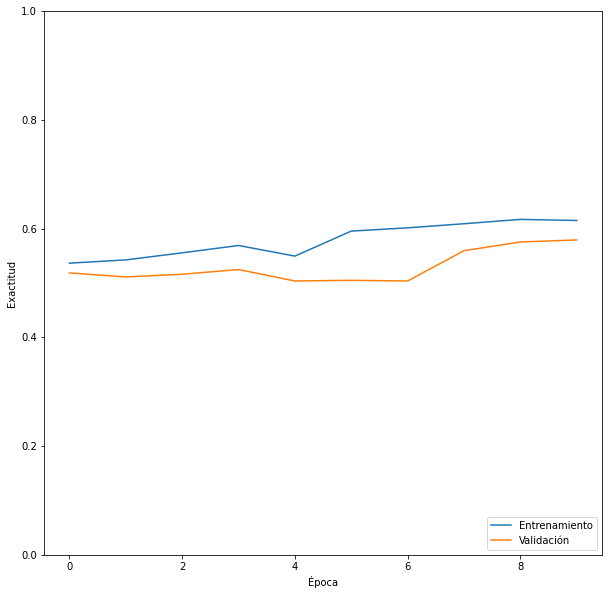

In [200]:
plot_history(history_base.history)

In [201]:
_, accuracy_base = model_base.evaluate(test_dataset, verbose=0)
print('Exactitud test base :', accuracy_base)

Exactitud test base : 0.5364583134651184


# Extracción de características

Ahora vamos a entrenar un modelo siguiendo una estrategía de transferencia de conocimiento empleando un modelo preentrenado como extractor de características, es decir, se van a congelar todas las capas a excepción de la capa final de clasificación que se sustituirá por un nuevo clasificador ajustado a nuestro problema.

Como arquitectura base vamos a emplear MobileNet V2 (desarrollado por Google). Este modelo está preentrenado en [ImageNet](https://en.wikipedia.org/wiki/ImageNet) con más de 14 millones de imágenes de más de 20.000 categorías.

Puedes ver una lista de modelos preentrenados en Keras aquí: https://keras.io/api/applications/


Dentro de la API de keras podemos encontrar el modelo preentrenado. Con el argumento **"include_top"** a "False" le estamos indicando que no se incluya la capa correspondiente a la clasificación. Con el argumento **"weights"** le estamos indicando que inicialice la arquitectura con los pesos que se obtuvieron al entrenarla con ImageNet.

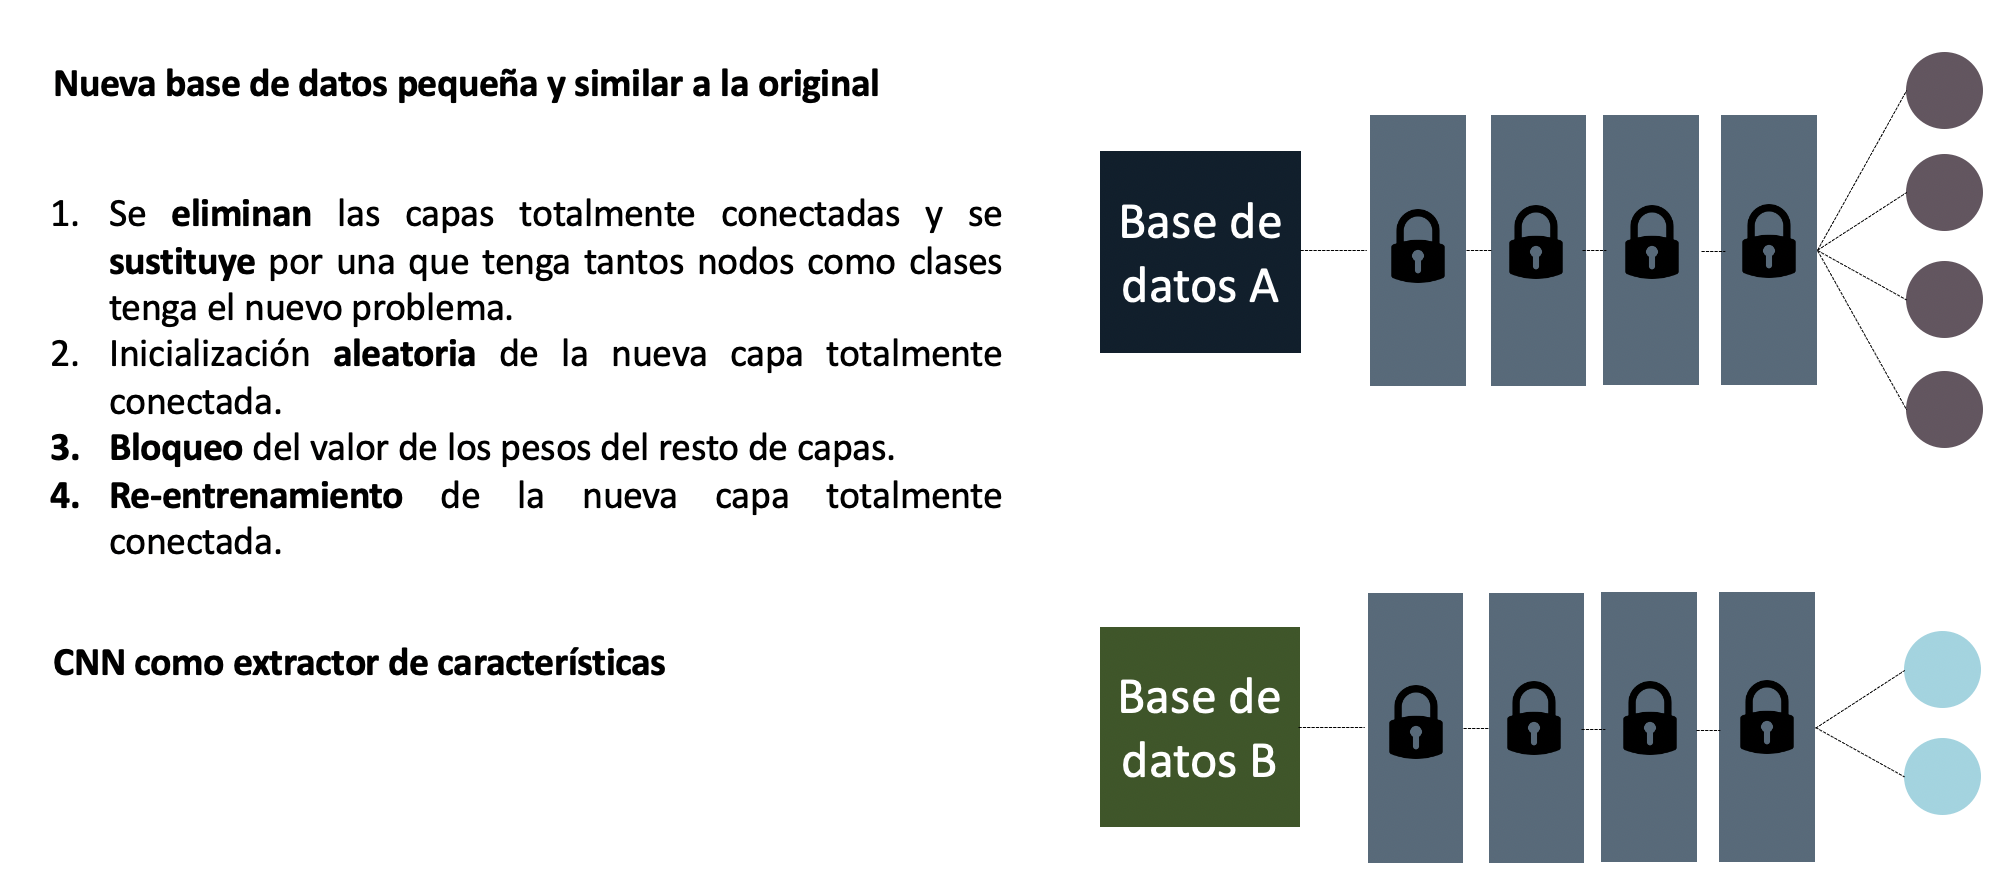

In [202]:
IMG_SHAPE = IMG_SIZE + (3,)
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [203]:
mobilenet_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_14[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [204]:
# Test para ver lo que devuelve con incude_top=True
# mobilenet_model_test = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                               include_top=True,
#                                               weights='imagenet')
# mobilenet_model_test.summary()

Esta arquitectura convierte una imágenen de 160x160x3 en un bloque de características de 5x5x1280.

Para emplear el modelo anterior como extractor de características, tenemos que congelar todo el bloque convolucional, para ello, se establecen todas las capas pertenecientes al bloque convolucional (todas las que hemos cargado anteriormente en mobilenet_model) como no entrenables.

Esto se podría realizar capa a capa si únicamente se quisieran congelar algunas en concreto, pero dado que queremos congelar todo el bloque podemos hacerlo directamente como:

In [205]:
mobilenet_model.trainable = False

**OJO!!!** El modelo MobileNetV2 se entrenó empleando un método de normalización basado en el reescalado de los valores de la imagen entre -1 y 1. Podemos emplear el método incluído en la propia API de keras para preprocesar la imagen de la misma forma que se realizó originalmente:

In [206]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

A continuación, a nuestro modelo le vamos a añadir la capa final de clasificación. 

Vamos a hacer uso de la capa "[GlobalAveragePooling2D](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/https://)" para realizar promedios espaciales de las imágenes de 5x5 que se obtenían a la salida del modelo base y convertirlo en un vector de características de 1280 mapas de características por imagen.

**¿Por qué GlobalAveragePooling y no Flatten como en ocasones anteriores?**

Son dos formas diferentes para conseguir "el mismo" resultado. La diferencia es que Flatten mantienen todas las componentes y generaría un vector de 5x5x1280=**32000** nodos, mientras que GlobalAveragePooling realiza el promedio de cada mapa dando lugar a **1280** nodos únicamente (menos nodos pero preservando la información más relevante).

In [207]:
def create_cnn_tc():

    input = Input(shape=(160, 160, 3))
    # Capa preprocesado
    x = preprocess_input(input)
    # Añadimos modelo base
    x = mobilenet_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # Clasificación binaria
    output = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=[input], outputs=[output])
  
    return model

model_tc = create_cnn_tc()
model_tc.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

Si echamos un vistazo al número de parámetros total y el entrenable, podemos ver como, correspondientes a la capa de "mobilenetv2" no se va a entrenar ningún parámetro. Todos los que se van a entrenar provienen de la capa totalmente conectada de clasificación.

In [208]:
model_tc.compile(optimizer='adam', 
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_tc = model_tc.fit(train_dataset,
                          epochs=10,
                          validation_data=validation_dataset,
                          verbose=1)

Epoch 1/10
63/63 [==============================] - 10s 98ms/step - loss: 0.1870 - accuracy: 0.9435 - val_loss: 0.0805 - val_accuracy: 0.9814
Epoch 2/10
63/63 [==============================] - 6s 84ms/step - loss: 0.0680 - accuracy: 0.9790 - val_loss: 0.0603 - val_accuracy: 0.9827
Epoch 3/10
63/63 [==============================] - 6s 84ms/step - loss: 0.0494 - accuracy: 0.9855 - val_loss: 0.0541 - val_accuracy: 0.9814
Epoch 4/10
63/63 [==============================] - 6s 85ms/step - loss: 0.0394 - accuracy: 0.9905 - val_loss: 0.0525 - val_accuracy: 0.9827
Epoch 5/10
63/63 [==============================] - 6s 84ms/step - loss: 0.0331 - accuracy: 0.9930 - val_loss: 0.0457 - val_accuracy: 0.9814
Epoch 6/10
63/63 [==============================] - 6s 85ms/step - loss: 0.0280 - accuracy: 0.9960 - val_loss: 0.0463 - val_accuracy: 0.9827
Epoch 7/10
63/63 [==============================] - 6s 85ms/step - loss: 0.0244 - accuracy: 0.9960 - val_loss: 0.0461 - val_accuracy: 0.9802
Epoch 8/10
6

In [209]:
# save_model(model_tc, '/content/drive/MyDrive/IES/clase/IA/Mis\ Apuntes/14.\ Transferencia\ de\ conocimiento/modelos/model_tc')

In [210]:
# model_tc, history_tc_history = load_model('/content/drive/MyDrive/IES/clase/IA/Mis\ Apuntes/14.\ Transferencia\ de\ conocimiento/modelos/model_tc.zip')

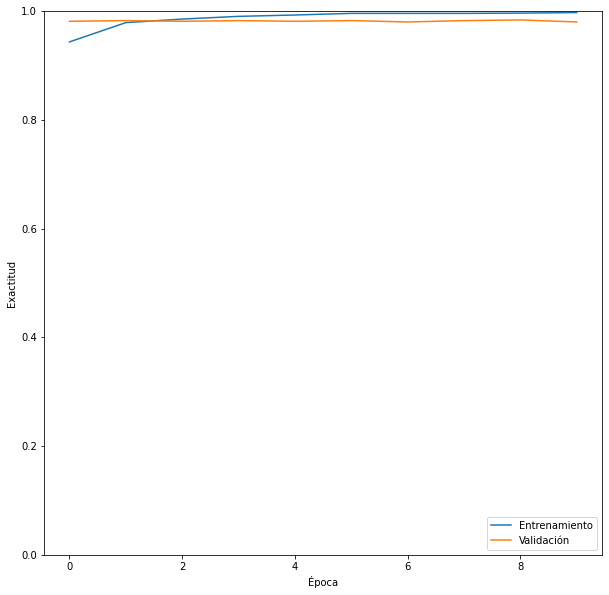

In [211]:
plot_history(history_tc.history)

In [212]:
_, accuracy_tc = model_tc.evaluate(test_dataset, verbose=0)
print('Exactitud test base :', accuracy_base)
print('Exactitud test transferencia conocimiento :', accuracy_tc)

Exactitud test base : 0.5364583134651184
Exactitud test transferencia conocimiento : 0.9895833134651184


Podemos observar la gran diferencia en el rendimiento del modelo. Realizando un poco más de experimentación sobre el modelo inicial seguramente hubiéramos llegado a conseguir mejores resultados, sin embargo, hubiera sido dificil alcanzar el mismo rendimiento que el que hemos obtenido con la transferencia de conocimiento.

También es cierto que la BBDD que hemos empleado tiene dos clases que ya están incluidas en la BBDD de imagenet, por lo tanto, se espera que el modelo se adapte facilmente a este problema. Generalmente, vamos a emplear BBDD con clases totalmente diferentes a las incluidas en ImageNet, en estos casos, también es recomendable evaluar la transferencia de conocimiento. En la mayoría de las ocasiones da mejores resultados que implementar una arquitectura desde cero con pesos inicializados de manera aleatoria.

# Ajuste fino

Como ya se ha comentado, en el experimento anterior no se han entrenado/ajustado las capas pertenecientes al modelo preentrenado. Una forma de aumentar todavía más el rendimiento del modelo es realizar un ajuste (fino) de los pesos de estas capas. De este modo, ajustaremos los filtros de las capas convolucionales a extraer mapas de características apropiados para la resolución del nuevo problema.
Este paso se recomienda incluirlo cuando el conjunto de datos de entrenamiento es grande y muy similar al conjunto de datos original en el que se entrenó el modelo preentrenado.

**NOTA IMPORTANTE**: Este ajuste fino debe de realizarse tras al ajuste de la capa de clasificación con las capas preentrenadas congeladas. Si se agrega el clasificador inicializado aleatoriamente y no se congelan las capas preentrenadas (se ajustan todos los pesos de la red), la magnitud de las actualizaciones de gradiente será demasiado grande (debido a los pesos aleatorios del clasificador) y el modelo entrenado previamente olvidará lo que ya ha aprendido.

No se va a realizar el ajuste de todas las capas preentrenadas, únicamente aquellas de más alto nivel que son las que están más especializadas en el problema para el que fueron entrenadas. Las primeras capas aprenden características más simples y genéricas que generalizan a casi todos los tipos de imágenes. De este modo, vamos a descongelar únicamente las capas superiores.

In [213]:
# Vemos el número de capas que tiene el modelo base
print("Número de capas en el modelo base: ", len(mobilenet_model.layers))

Número de capas en el modelo base:  154


Vamos a ajustar las capas desde la capa 100

In [214]:
# Volvemos a descongelar el modelo
mobilenet_model.trainable = True

# Como ahora solo queremos entrenar capas específicas, vamos a congelar las capas concretas que no queremos reentrenar (hasta la 100)
for layer in mobilenet_model.layers[:100]:
  layer.trainable =  False

**NOTA IMPORTANTE:** Como solo queremos readaptar unos pesos ya entrenados, se va a emplear una tasa de aprendizaje pequeña para evitar el sobreajuste.


**OJO!!!** Fíjate que **model_tc no lo estamos instanciando de nuevo**, sino que vamos a entrenar con los pesos calculados en el entrenamiento anterior, donde hemos calculado los pesos de la red de clasificación, para evitar que los pesos de las capas convolucionales no bloqueadas se modifiquen en exceso.

In [215]:
model_tc.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

model_tc.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

Vemos como ahora hay más parámetros a entrenar. Estos parámetros adicionales son los que provienen del modelo preentrenado (mobilenetv2).

Entrenamos durante 5 épocas más

In [216]:
history_fine = model_tc.fit(train_dataset,
                            epochs=5,
                            validation_data=validation_dataset,
                            verbose=1)

Epoch 1/5
63/63 [==============================] - 14s 125ms/step - loss: 0.0188 - accuracy: 0.9945 - val_loss: 0.0473 - val_accuracy: 0.9802
Epoch 2/5
63/63 [==============================] - 7s 110ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.0417 - val_accuracy: 0.9839
Epoch 3/5
63/63 [==============================] - 7s 110ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0428 - val_accuracy: 0.9839
Epoch 4/5
63/63 [==============================] - 7s 111ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0449 - val_accuracy: 0.9864
Epoch 5/5
63/63 [==============================] - 7s 110ms/step - loss: 4.3989e-04 - accuracy: 1.0000 - val_loss: 0.0510 - val_accuracy: 0.9851


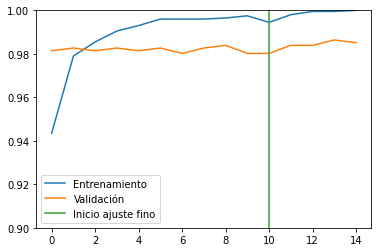

In [217]:
# Analizamos conjuntamente la precisión en entrenamiento y validación al congelar todas las capas y tras descongelar algunas de ellas

acc = history_tc.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_tc.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.plot(acc, label='Entrenamiento')
plt.plot(val_acc, label='Validación')
plt.ylim([0.9, 1])
plt.plot([10,10],
          plt.ylim(), label='Inicio ajuste fino')
plt.legend()

In [226]:
# Vemos que ocurre en el conjunto de datos de test

_, accuracy_fine = model_tc.evaluate(test_dataset, verbose=0)
print('Exactitud test base :', accuracy_base)
print('Exactitud test transferencia conocimiento :', accuracy_tc)
print('Exactitud test transferencia conocimiento y ajuste fino :', accuracy_fine)

Exactitud test base : 0.5364583134651184
Exactitud test transferencia conocimiento : 0.9895833134651184
Exactitud test transferencia conocimiento y ajuste fino : 0.9947916865348816


In [ ]:
model_tc.evaluate(test_dataset, verbose=0)

# Inferencia

Finalmente vamos a hacer inferencia sobre un conjunto de imágenes del dataset de test.


Probabilidad:  [1.8585168e-07 9.9999952e-01 7.7176956e-08 1.0000000e+00 2.0119646e-06
 2.7351609e-01 9.9999273e-01 9.9875543e-08 5.8784821e-09 9.9999225e-01
 9.9999940e-01 3.8106172e-08 1.7896153e-06 9.9998713e-01 6.9786159e-07
 9.9998164e-01 9.9956673e-01 1.0000000e+00 1.0000000e+00 9.9784636e-01
 5.1181894e-07 1.6962751e-06 1.0000000e+00 9.9999988e-01 2.2718501e-08
 9.9999619e-01 1.0000000e+00 1.0000000e+00 9.9999511e-01 6.5759576e-09
 9.9999988e-01 3.0960728e-05]
Etiquetas predichas:  [0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 0.]


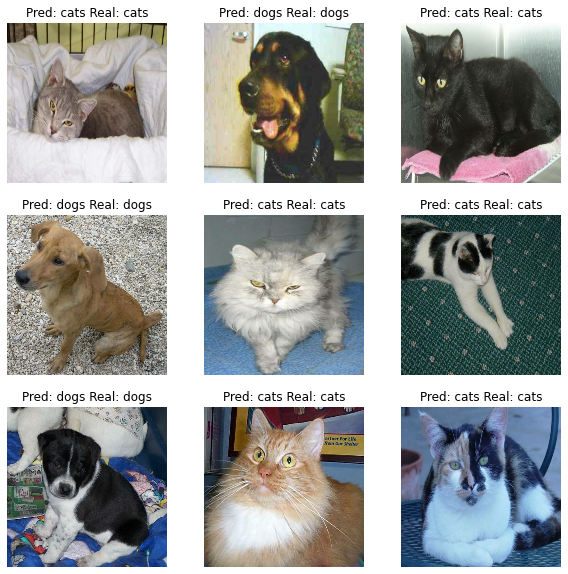

In [219]:
# Cogemos un batch de imágenes del set de test
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_tc.predict_on_batch(image_batch).flatten()

print('Probabilidad: ', predictions)

# Establecemos umbral en 0.5 para diferenciar entre clases
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

print('Etiquetas predichas: ', predictions)

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('Pred: ' + class_names[int(predictions[i])] + ' Real: ' + class_names[int(label_batch[i])])
  plt.axis("off")

Finalmente, vamos a ver algún caso en el que la clasificación no se haya realizado correctamente.

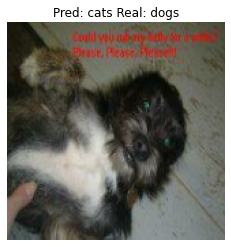

In [220]:
ind_different = np.where(predictions != label_batch)[0]

while len(ind_different) == 0:

  image_batch, label_batch = test_dataset.as_numpy_iterator().next()
  predictions = model_tc.predict_on_batch(image_batch).flatten()

  # Establecemos umbral en 0.5 para diferenciar entre clases
  predictions[predictions >= 0.5] = 1
  predictions[predictions < 0.5] = 0

  ind_different = np.where(predictions != label_batch)[0]

for i in ind_different:
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('Pred: ' + class_names[int(predictions[i])] + ' Real: ' + class_names[int(label_batch[i])])
  plt.axis("off")
  plt.show()
